In [97]:
import torch
import numpy as np
from datasets import Dataset, Image
# from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, MaskFormerForInstanceSegmentation, TrainingArguments, Trainer, MaskFormerConfig, MaskFormerModel, MaskFormerImageProcessor
from PIL import Image as PILImage
from sklearn.model_selection import train_test_split
import glob

from typing import Dict, List, Mapping
from transformers.trainer import EvalPrediction
# from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics import JaccardIndex, Accuracy
from dataclasses import dataclass

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import os
import cv2

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = "cuda" if torch.cuda.is_available() else "cpu"

IMAGE_SIZE = (512, 512)  # Resize images to this size

id2label = {0: 'background', 1: 'water'}
label2id = {label: id for id, label in id2label.items()}
NUM_CLASSES = len(id2label)

MODEL_CHECKPOINT = "maskformer_water"

config = MaskFormerConfig.from_pretrained(MODEL_CHECKPOINT)
config.id2label = id2label
config.label2id = label2id
config.num_labels = NUM_CLASSES

# Use the config object to initialize a MaskFormer model with randomized weights
model = MaskFormerForInstanceSegmentation(config)

base_model = MaskFormerModel.from_pretrained(MODEL_CHECKPOINT)
model.model = base_model

# processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)
MODEL_CHECKPOINT = "facebook/maskformer-resnet50-coco-stuff"
processor = MaskFormerImageProcessor.from_pretrained(MODEL_CHECKPOINT)

model.to(device)

MaskFormerForInstanceSegmentation(
  (model): MaskFormerModel(
    (pixel_level_module): MaskFormerPixelLevelModule(
      (encoder): ResNetBackbone(
        (embedder): ResNetEmbeddings(
          (embedder): ResNetConvLayer(
            (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): ReLU()
          )
          (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (encoder): ResNetEncoder(
          (stages): ModuleList(
            (0): ResNetStage(
              (layers): Sequential(
                (0): ResNetBottleNeckLayer(
                  (shortcut): ResNetShortCut(
                    (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                    (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [99]:
test_image_dir = "./sar_images/images/test/*.png"
test_mask_dir = "./sar_images/masks/test/*.png"

test_images_paths = list(glob.glob(test_image_dir))
# images = [str(path) for path in images]
test_masks_paths = [path.replace('/images', '/masks') for path in test_images_paths]


In [100]:
alb_transform = A.Compose([
    A.Resize(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    ToTensorV2()
])

def create_dataset(image_paths, mask_paths):
    
    images = []
    masks = []
    
    for img_path, mask_path in zip(image_paths, mask_paths):
        
        # print(img_path, mask_path)
        
        # Open images and masks
        image = np.array(PILImage.open(img_path).convert("RGB"))
        mask = np.array(PILImage.open(mask_path).convert("L"), dtype=np.uint8)  # Convert mask to grayscale

        mask[mask == 255] = 1  # Convert 255 to 1
        # Apply Albumentations transform
        transformed = alb_transform(image=image, mask=mask)
        
        # Extract transformed image and mask
        image = transformed["image"]
        mask = transformed["mask"].long()  # Ensure mask is long tensor
        
        images.append(image)
        masks.append(mask)
                
    return images, masks

# Create dataset from file paths
test_images, test_masks = create_dataset(test_images_paths, test_masks_paths)

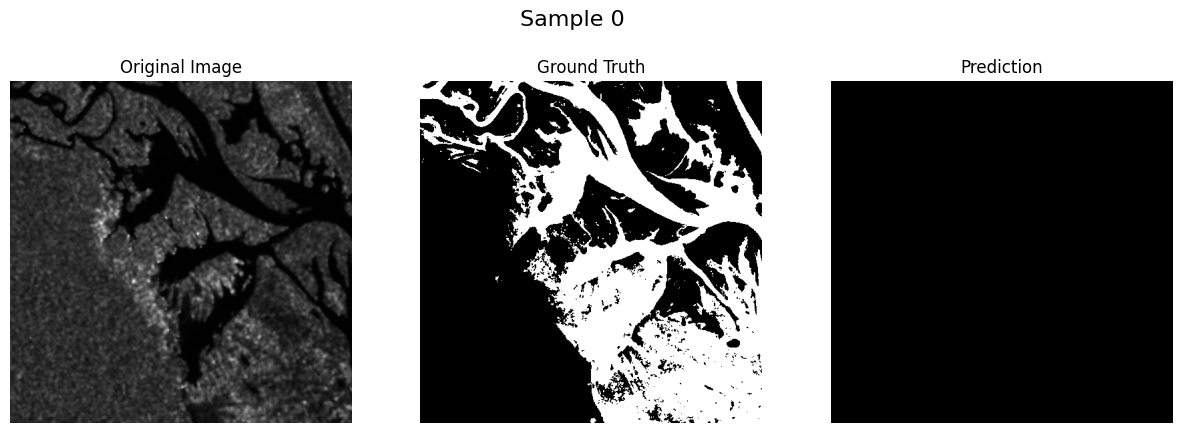

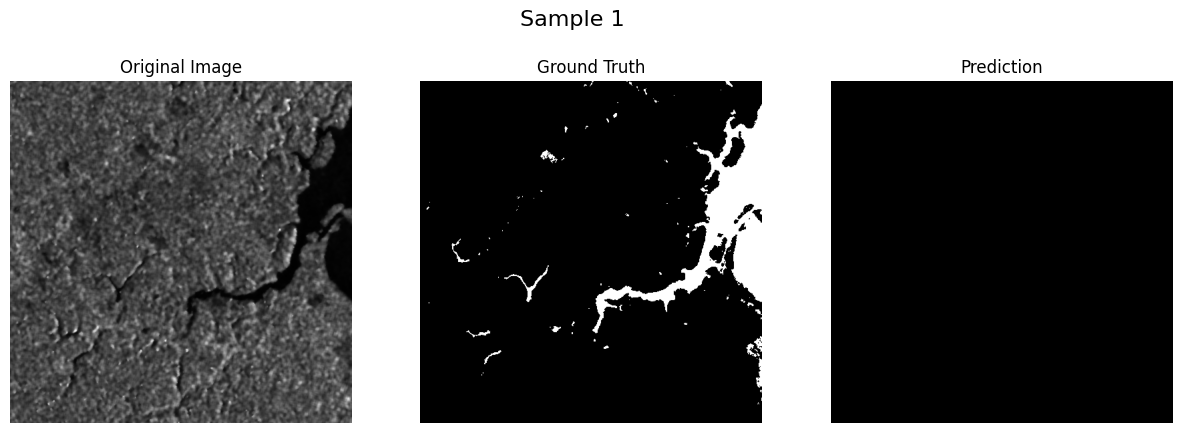

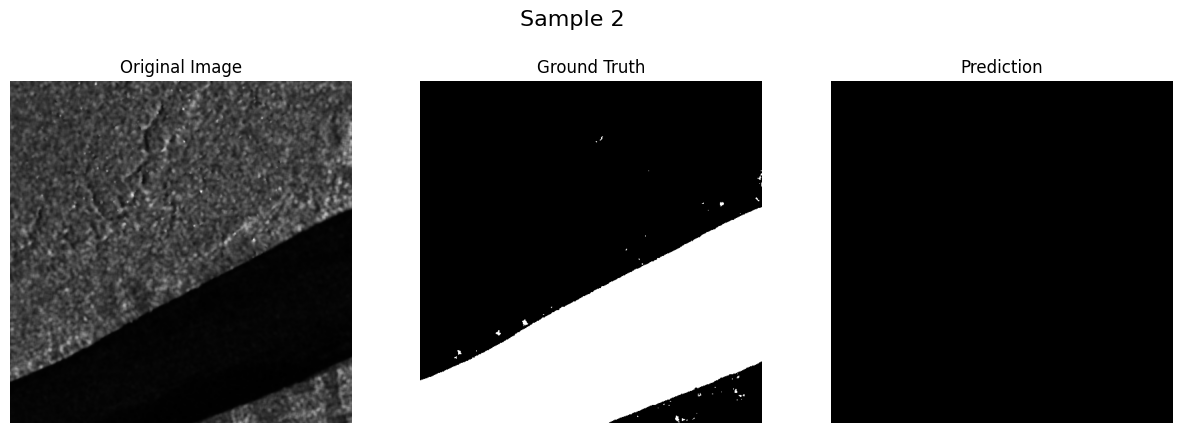

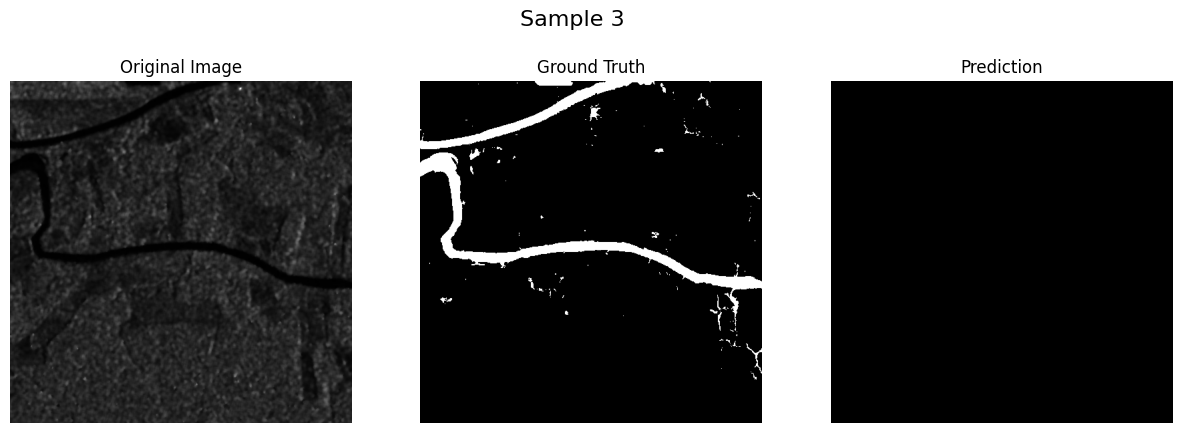

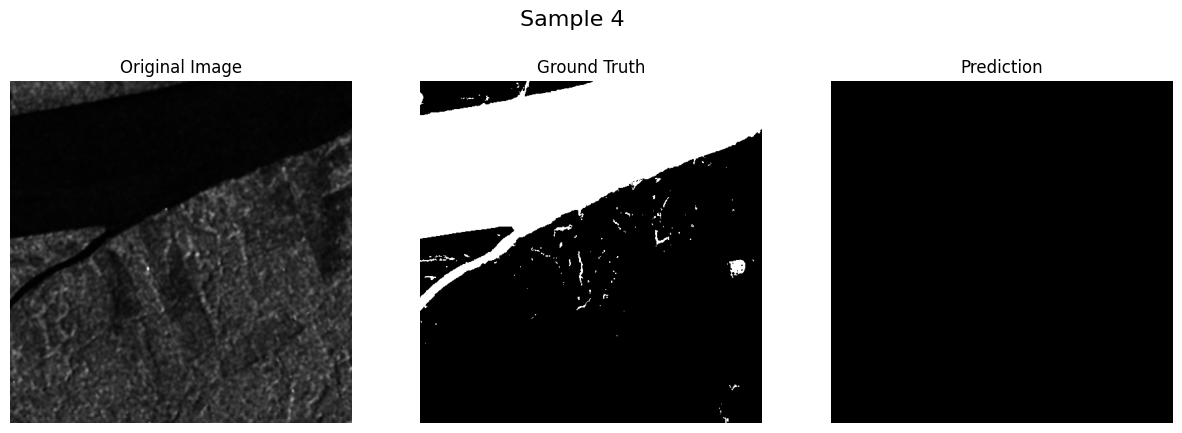

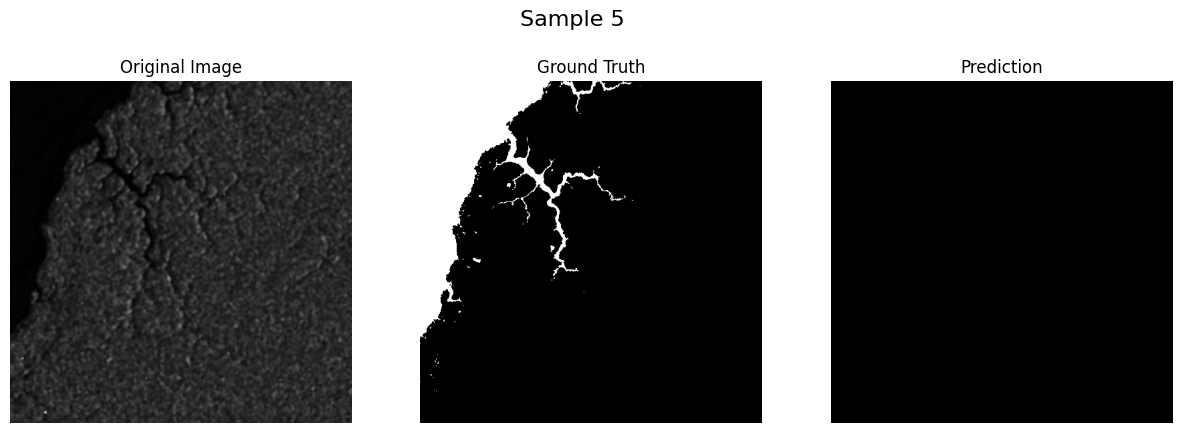

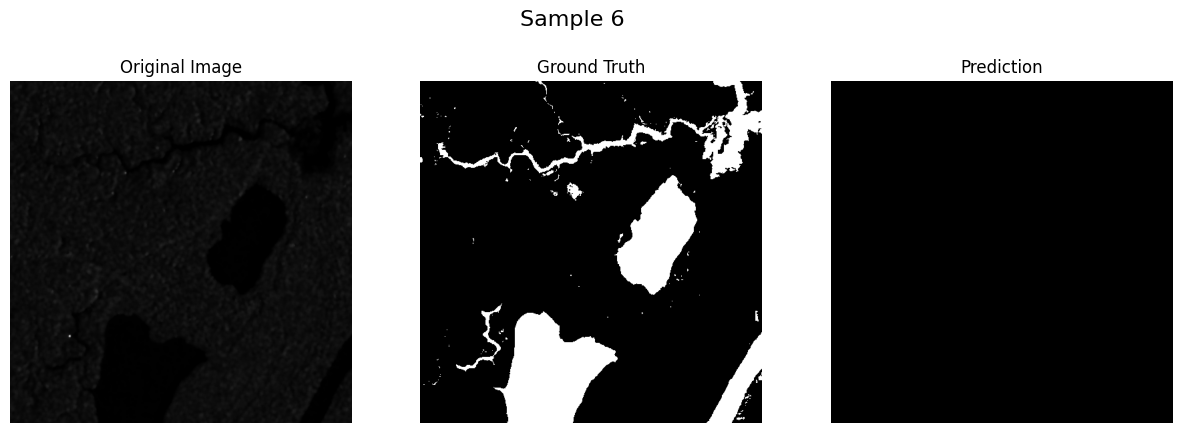

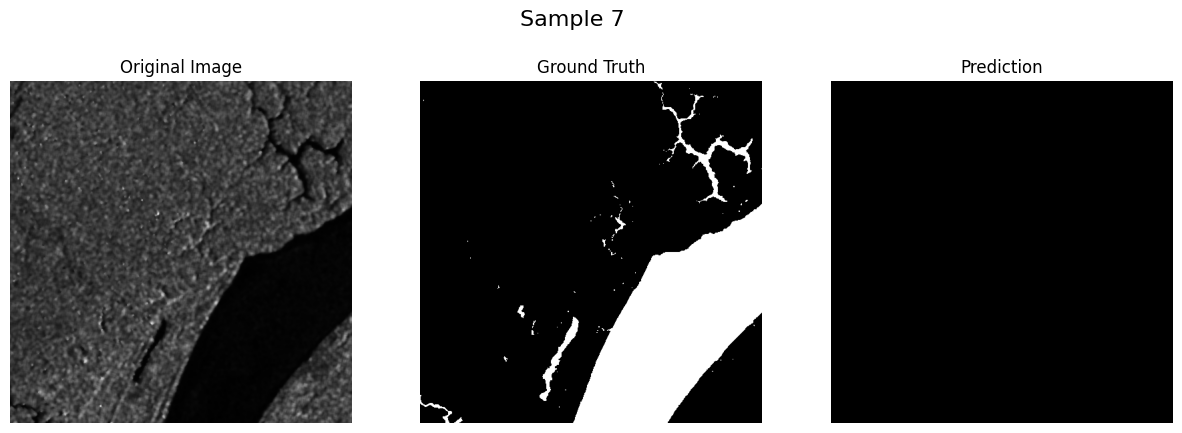

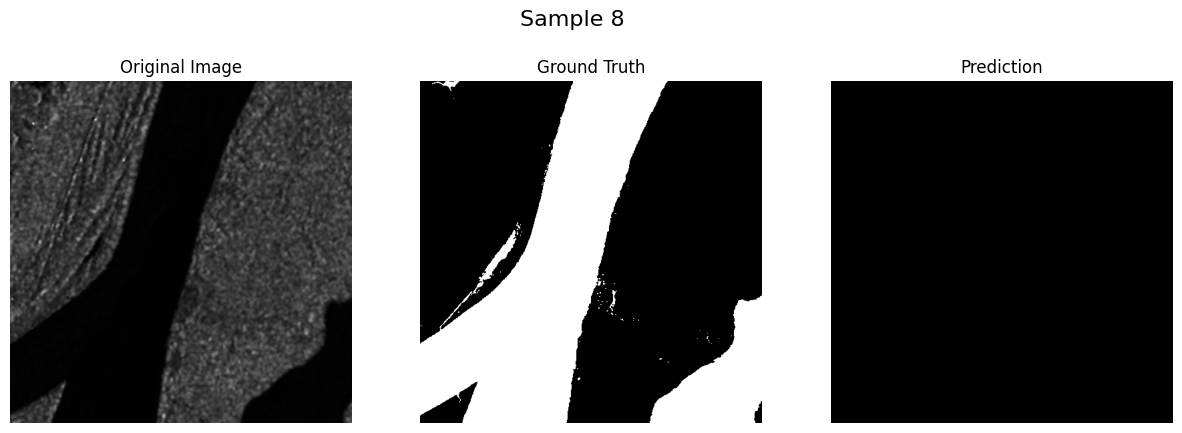

KeyboardInterrupt: 

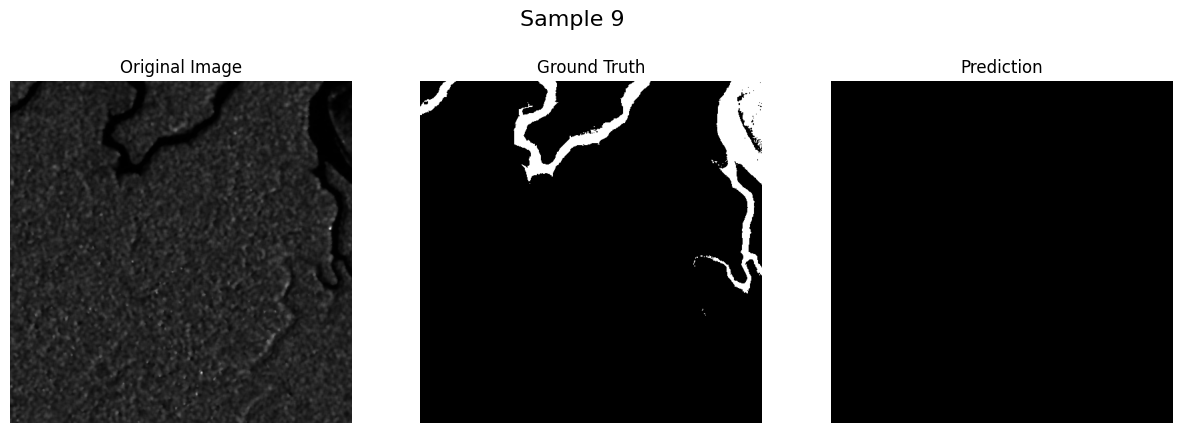

In [101]:
def visualize(image, mask, pred, idx, name):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Sample {idx}', fontsize=16)

    #if image.shape[0] == 3:
       # image = inv_normalize(image).permute(1, 2, 0).numpy()
    #else:
    # image = image.permute(1, 2, 0).numpy()
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title('Prediction')
    axes[2].axis('off')

    plt.savefig(f"./GEE_Output/Maskformer/Visualizations/{name}")
    plt.show()
    
output_dir = "./GEE_Output/Maskformer/Outputs"
for i in range(len(test_images)):
    
    image = test_images[i].cpu().numpy()
    image = PILImage.fromarray(image.transpose(1, 2, 0), mode='RGB')    
    mask = test_masks[i]
    name = test_images_paths[i]
    
    inputs = processor(image, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)

    class_queries_logits = outputs.class_queries_logits
    masks_queries_logits = outputs.masks_queries_logits   
    
    predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    name = os.path.basename(name)
    pred_mask = predicted_semantic_map.cpu().numpy()
    
    pred_norm = pred_mask * 255
    pred_norm = pred_norm.astype(np.uint8)
    pred_path = os.path.join(output_dir, f"pred_{name}")
    cv2.imwrite(pred_path, pred_norm)
    visualize(np.array(image), mask, pred_mask, i, name)
